# Import Libraries

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

# Load Dataset

In [43]:
# load dataset
df = pd.read_csv('/content/Churn_Modelling.csv')
df.head()


RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

# EDA

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [45]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [46]:
df.duplicated().sum()

0

- None of the columns is having missing values.  
- There are no duplicate records present in the dataset.



In [47]:
df.describe(include="object").T

count unique     top  freq
Surname    10000   2932   Smith    32
Geography  10000      3  France  5014
Gender     10000      2    Male  5457

Surname column has too many unique values and doesn't significantly impact whether a customer will churn or not. we can drop this column from the dataset.

In [48]:
# drop unrelevant columns
df.drop(columns=["RowNumber","CustomerId","Surname"],inplace=True)

In [49]:
df.head()

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   
4          850     Spain  Female   43       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0          1               1        101348.88       1  
1          0               1        112542.58       0  
2          1               0        113931.57       1  
3          0               0         93826.63       0  
4          1               1         79084.10       0

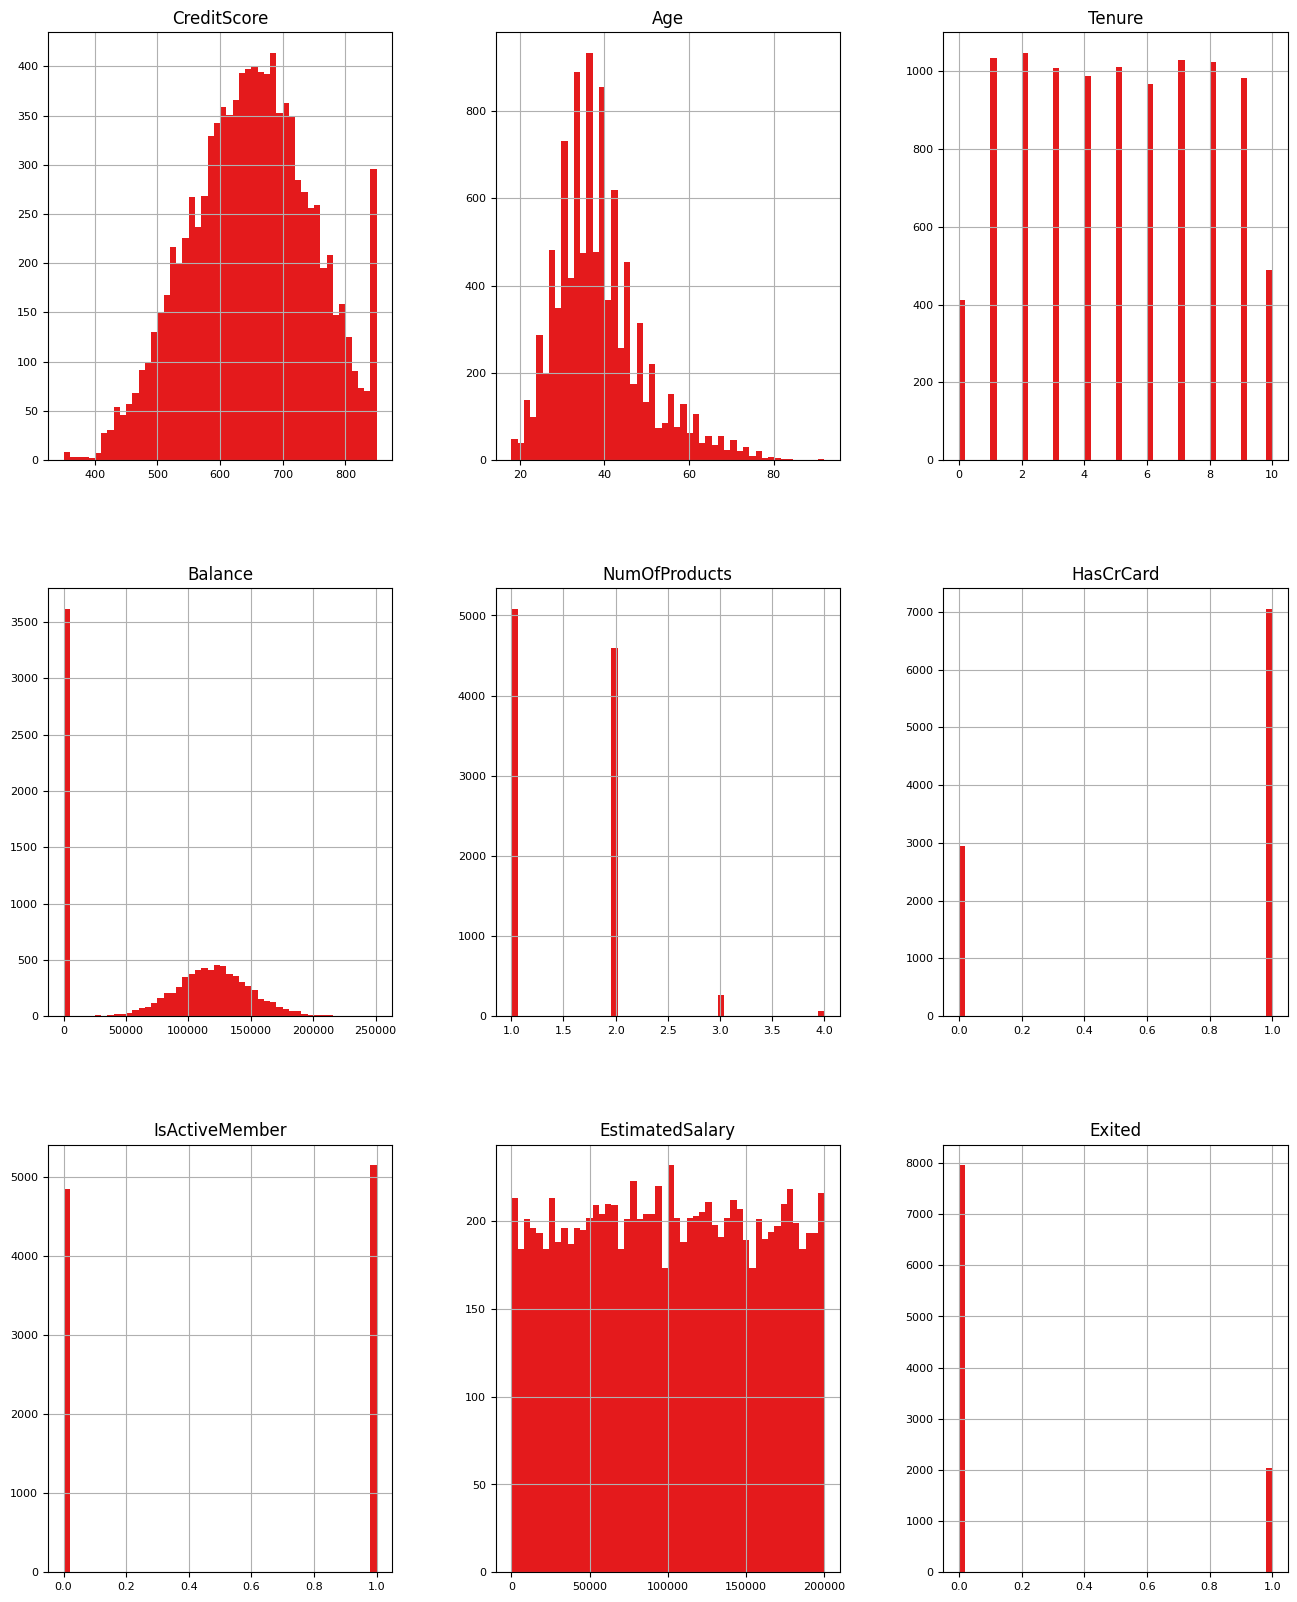

In [50]:
df.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

- in "Balance" distribution, over 3,000 customers are likely to have deactivated their account balances.

In [51]:
df['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

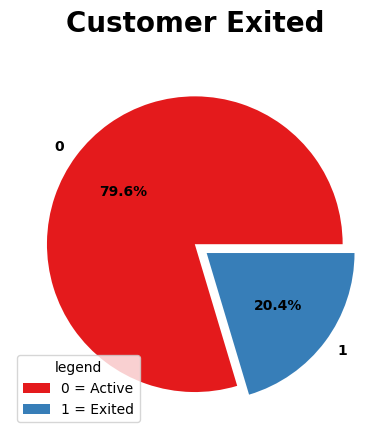

In [52]:
count = df["Exited"].value_counts()

plt.subplot()
plt.pie(count.values, labels=count.index, autopct="%1.1f%%",colors=sns.set_palette("Set1"),
        textprops={"fontweight":"black"},explode=[0,0.1])
plt.title("Customer Exited",fontweight="black",size=20,pad=20)

# add legend
plt.legend(
    labels=["0 = Active", "1 = Exited"],
    loc="lower left",
    title="legend",
    fontsize=10
)
plt.show()

the data is imbalance (20.4% churned and 79.6% non-churned) it can affect the performance of machine learning models. Models tend to focus more on the majority class (non-churned customers), making predictions for the minority class (churned customers) less accurate. we will use SMOTE for over sampling

# Feature Engineering

In [53]:
# identify categorical object
cats = df.select_dtypes(include=['object']).columns

# mapping for every columns
mappings = {col: {i: category for i, category in enumerate(df[col].dropna().unique())} for col in cats}

# print results
for col, mapping in mappings.items():
    print(f"colums '{col}': {mapping}")


colums 'Geography': {0: 'France', 1: 'Spain', 2: 'Germany'}
colums 'Gender': {0: 'Female', 1: 'Male'}


In [54]:
# convet categorical cols to nums
df[cats] = df[cats].apply(lambda col: col.astype('category').cat.codes)
df.head()

CreditScore  Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619          0       0   42       2       0.00              1   
1          608          2       0   41       1   83807.86              1   
2          502          0       0   42       8  159660.80              3   
3          699          0       0   39       1       0.00              2   
4          850          2       0   43       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0          1               1        101348.88       1  
1          0               1        112542.58       0  
2          1               0        113931.57       1  
3          0               0         93826.63       0  
4          1               1         79084.10       0

In [55]:
# split data to feature and target
X = df.drop(columns=["Exited"])
y = df["Exited"]

# split train and test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)

## SMOTE

In [56]:
# using SMOTE for imbalance target class
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Class distribution before SMOTE:")
print(y_train.value_counts())

print("\nClass distribution after SMOTE:")
print(y_train_smote.value_counts())

Class distribution before SMOTE:
Exited
0    6370
1    1630
Name: count, dtype: int64

Class distribution after SMOTE:
Exited
1    6370
0    6370
Name: count, dtype: int64


## Scaling

In [57]:
# scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

# Modelling

## Support Vector Machine

In [71]:
svm = SVC()
svm.fit(X_train_scaled, y_train_smote)

SVC()

In [72]:
y_pred = svm.predict(X_test_scaled)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.83      0.87      1593
           1       0.50      0.66      0.57       407

    accuracy                           0.80      2000
   macro avg       0.70      0.75      0.72      2000
weighted avg       0.82      0.80      0.81      2000


Confusion Matrix:
[[1325  268]
 [ 139  268]]


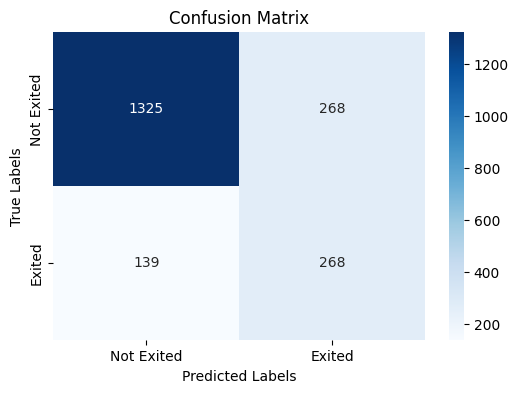

In [61]:
# generate and visualize confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# visualize confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Exited', 'Exited'], yticklabels=['Not Exited', 'Exited'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Classification Report:  
- Accuracy (0.80): The model successfully predicted 80% of the total data correctly.
- Macro Average (Average for both classes without considering data distribution):  
  - Precision (0.70), Recall (0.75), F1-Score (0.72): The average performance shows an imbalance in performance between classes.
- Weighted Average (Average based on class distribution):
  - Precision (0.82), Recall (0.80), F1-Score (0.81): Giving more weight to the majority class (Not Exited), so the metrics look higher.
    

Confusion Matrix
- True Negatives (1325): Number of customers who actually did not churn and were predicted not to churn.  
- False Positives (268):
Number of customers who actually did not churn, but were predicted to churn.  
- False Negatives (139):
Number of customers who actually churned, but were predicted not to churn.  
- True Positives (268):
Number of customers who actually churned and were predicted to churn.  

## Logistic Regression

In [74]:
logreg = LogisticRegression()
logreg.fit(X_train_scaled, y_train_smote)

LogisticRegression()

In [75]:
y_pred = logreg.predict(X_test_scaled)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.76      0.82      1593
           1       0.40      0.62      0.48       407

    accuracy                           0.73      2000
   macro avg       0.64      0.69      0.65      2000
weighted avg       0.79      0.73      0.75      2000


Confusion Matrix:
[[1209  384]
 [ 155  252]]


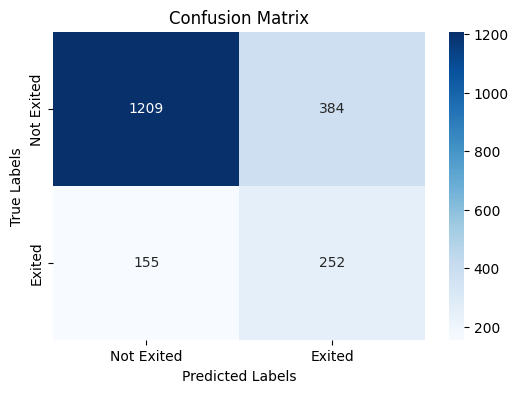

In [76]:
# generate and visualize confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# visualize confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Exited', 'Exited'], yticklabels=['Not Exited', 'Exited'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

Classification Report :
- Accuracy (0.73): The model successfully predicted 73% of the total data correctly.
- Macro Average (Average for both classes regardless of data distribution):
  - Precision (0.64), Recall (0.69), F1-Score (0.65): Shows lower average performance for the churned class.
- Weighted Average (Average based on class distribution):
  - Precision (0.79), Recall (0.73), F1-Score (0.75): Higher weighting on the majority (non-churn) class improves this metric.

Confusion Matrix :
- True Negatives (1209): Number of customer who actually did not churn and were predicted not to churn.
- False Positives (384): Number of customer who actually did not churn, but were predicted to churn.
- False Negatives (155): Number of customer who actually churn, but were predicted not to churn.
- True Positives (252): Number of customer who actually churn and were predicted to churn.

# Model Evaluate
- SVM outperforms in precision and recall for the non-churn class and also performs better for the churn class compared to Logistic Regression.
- Logistic Regression have very low precision predicting churn (minority class) with  (0.40), while SVM is slightly better in this regard (0.50).
- Accuracy for SVM (0.80) is higher than Logistic Regression (0.73).
- The SVM model produces a better F1-score overall.